# Setting up Hyperparameters

In [1]:
epochs = 15
negative_mining = False
soft_labels = False
nb_augment = 0
load_data_on_GPU = True

In [2]:
batch_size = 4
learning_rate = 1e-4

In [3]:
using_train_dataset = "CS9"
using_eval_dataset = "CS9"

### Selecting the correct device for training (CPU or GPU)

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Importing the Data

##### Creating the Input Pipeline

In [5]:
from torchvision.transforms.functional import invert
from torch.nn.functional import normalize

from pipelines import InputPipeline, LaplacianFilter

inpip = InputPipeline(
    transformer=normalize,
    layer_transformer=[LaplacianFilter()])

inpip = inpip.to(device)

## Creating Training Dataset

##### Train data from CrackSeg9K Dataset

In [6]:
from torchvision.transforms import GaussianBlur

if using_train_dataset == "CS9":

    from dataset import CS9DataReader, CS9Dataset

    train_data_reader = CS9DataReader(root_dir="../data/CrackSeg9k/", mode="Train", load_on_gpu=load_data_on_GPU, verbose=True)
    train_data = train_data_reader.data

    training_dataset = CS9Dataset(
        train_data,
        transform=inpip,
        target_transform= GaussianBlur(kernel_size=3, sigma=0.7) if soft_labels else None,
        load_on_gpu=load_data_on_GPU,
        verbose=True
    )

    training_dataset.precompute_transform(verbose=True)

Loading dataset into GPU:   0%|          | 0/4829 [00:00<?, ?it/s]

	- Loading done, GPU memory used: 2.88GiB / free: 18.64GiB / total: 22.17GiB
	- Got a total of 4829 images.
	- Loading done, GPU memory used: 2.88GiB / free: 18.64GiB / total: 22.17GiB


Applying transform to the Dataset:   0%|          | 0/4829 [00:00<?, ?it/s]

	- Transformation done, GPU memory used: 6.48GiB / free: 14.43GiB / total: 22.17GiB


##### Train data from POC Dataset

In [7]:
from torch.nn import Sequential
from torchvision.transforms import CenterCrop, Resize, GaussianBlur

if using_train_dataset == "POC":

    from dataset import POCDataReader, data_augment_, POCDataset

    data_reader = POCDataReader(root_dir="../data/POC", load_on_gpu=load_data_on_GPU, verbose=True)
    train_data = data_reader.data
    # data_augment_(train_data, n=nb_augment, load_on_gpu=load_data_on_GPU, verbose=True)

    training_dataset = POCDataset(
        train_data,
        transform=Sequential(
            inpip,
            CenterCrop(size=(480, 480)),
            Resize(size=(400, 400)),
        ),
        target_transform=Sequential(
            GaussianBlur(kernel_size=3, sigma=0.7),
            CenterCrop(size=(480, 480)),
            Resize(size=(400, 400)),
        ) if soft_labels else Sequential(
            CenterCrop(size=(480, 480)),
            Resize(size=(400, 400)),
        ),
        load_on_gpu=load_data_on_GPU,
        verbose=True
    )

    training_dataset.precompute_transform(verbose=True)

### Training Dataloader

In [8]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(training_dataset, lengths=[.9, .1])

In [9]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    training_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
else:
    training_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

In [10]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    validation_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
else:
    validation_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

## Creating Evaluation Dataset

##### Evaluation data from CS9 Dataset

In [11]:
from torch.nn.functional import normalize

if using_eval_dataset == "CS9":

    from dataset import CS9DataReader, CS9Dataset

    test_data_reader = CS9DataReader(root_dir="../data/CrackSeg9k/", mode="Test", load_on_gpu=load_data_on_GPU, verbose=True)
    test_data = test_data_reader.data
    
    test_dataset = CS9Dataset(
        test_data,
        transform=inpip,
        target_transform= GaussianBlur(kernel_size=3, sigma=0.7) if soft_labels else None,
        load_on_gpu=load_data_on_GPU,
        verbose=True
    )

Loading dataset into GPU:   0%|          | 0/1204 [00:00<?, ?it/s]

	- Loading done, GPU memory used: 7.20GiB / free: 13.71GiB / total: 22.17GiB
	- Got a total of 1204 images.
	- Loading done, GPU memory used: 7.20GiB / free: 13.71GiB / total: 22.17GiB


##### Evaluation data from POC Dataset

In [12]:
from torch.nn.functional import normalize

if using_eval_dataset == "POC":

    from dataset import POCDataReader, data_augment_, POCDataset

    test_data_reader = POCDataReader(root_dir="../data/POC", load_on_gpu=load_data_on_GPU, verbose=True)
    test_data = test_data_reader.data
    # data_augment_(train_data, n=nb_augment, load_on_gpu=load_data_on_GPU, verbose=True)

    test_dataset = POCDataset(
        test_data,
        transform=Sequential(
            inpip,
            CenterCrop(size=(480, 480)),
            Resize(size=(400, 400)),
        ),
        target_transform=Sequential(
            GaussianBlur(kernel_size=3, sigma=0.7),
            CenterCrop(size=(480, 480)),
            Resize(size=(400, 400)),
        ) if soft_labels else Sequential(
            CenterCrop(size=(480, 480)),
            Resize(size=(400, 400)),
        ),
        load_on_gpu=load_data_on_GPU,
        verbose=True
    )

### Evaluation Dataloader

In [13]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    evaluation_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
    )
else:
    evaluation_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

## Testing the dataloader

torch.Size([4, 4, 400, 400]) torch.Size([4, 2, 400, 400])
('noncrack_noncrack_concrete_wall_20_15.png', 'Rissbilder_for_Florian_9S6A2850_223_94_3413_2683.png', 'noncrack_noncrack_concrete_wall_75_1.png', 'CRACK500_20160306_103638_1921_721.png') tensor([3846, 2634, 4545,  176])


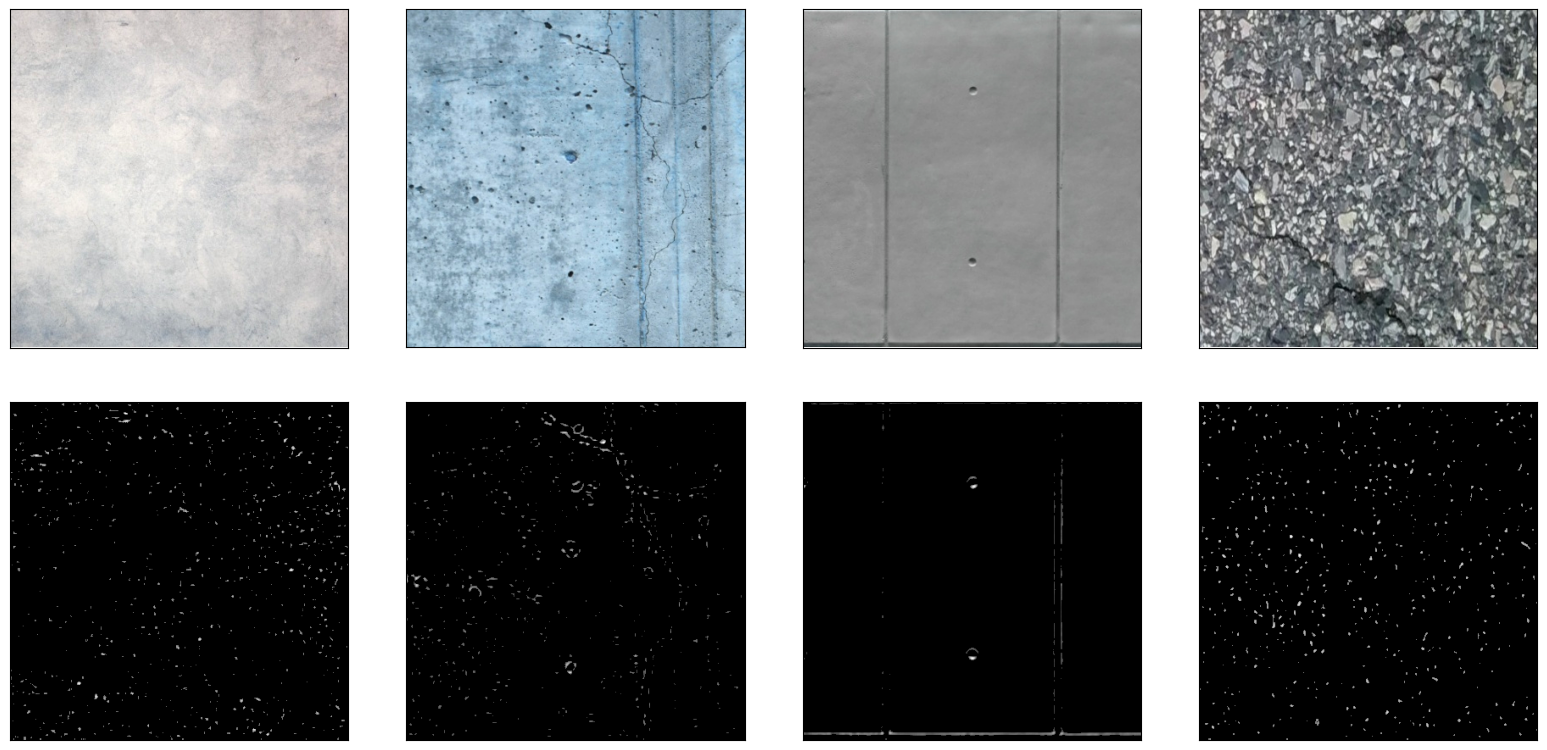

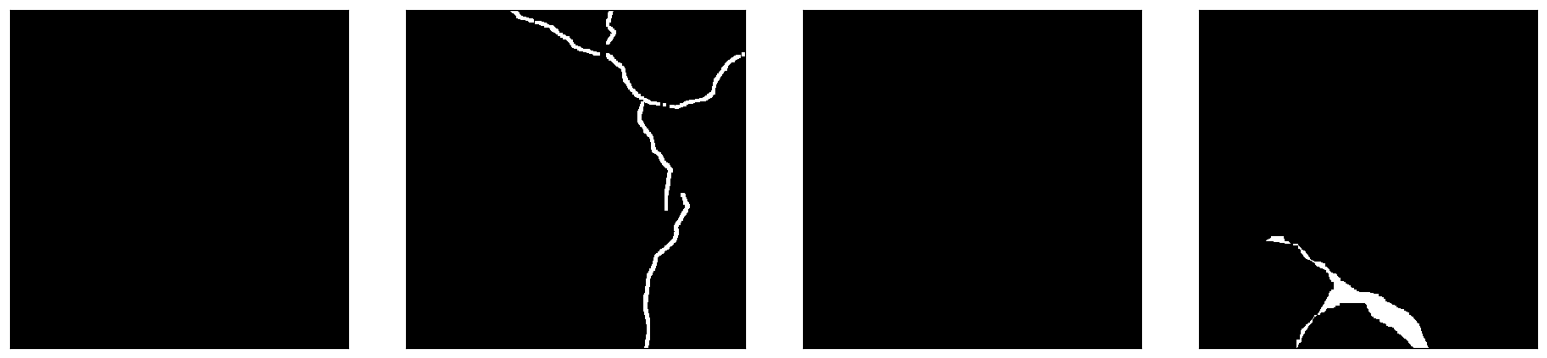

In [14]:
from my_utils import show_img

features, masks, files, indexes = next(iter(training_dataloader))
print(features.size(), masks.size())

show_img(features)
show_img(masks)
print(files, indexes)

### Testing Dataset for proportion between classes

In [15]:
_,train_labels,_,_ = next(iter(training_dataloader))

nb_pixel = train_labels.argmax(dim=1, keepdim=False).unique(return_counts=True)[1]
print("Proportion of class 1 in this batch: {}%".format(nb_pixel[1] * 100 / (nb_pixel[0] + nb_pixel[1])))

Proportion of class 1 in this batch: 0.5181249976158142%


Result is around 3%.

# Building the differents modules

## Creating the models

#### Using Unet with bilinear upsampling and cropping to generate 2 classes (background and crack).

In [16]:
from models import UNet

model = UNet(n_channels=inpip.nb_channel, n_classes=2, bilinear=True, crop=False).to(device)

In [17]:
print("Total number of parameters: {0:,}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
print(f"Model structure: {model}")

Total number of parameters: 17,268,034
Model structure: UNet(
  (in_conv): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=Tru

## Creating the loss functions

#### Combined (Focal + Jaccard) Loss

In [18]:
import torch
from loss import CombinedLoss, JaccardLoss, FocalLoss

weight = torch.tensor([.3, .7])

loss_fn = CombinedLoss(
    FocalLoss(weight=weight, gamma=2),
    JaccardLoss(),
    ratio=0.75).to(device)

## Creating the Optimizer

In [19]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99))

## Setting up the Learning Rate Scheduler

In [20]:
from torch.optim.lr_scheduler import CosineAnnealingLR

lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

## Creating the Metrics

In [21]:
from metrics import Metrics, EvaluationMetrics


train_metrics = Metrics(
    buffer_size=len(training_dataloader),
    mode="Training",
    hyperparam={
        'Network': model.__class__.__name__,
        'Optimizer': optimizer.__class__.__name__,
        'Combine Loss': loss_fn.__class__.__name__,
        'Pixel Loss': "FocalLoss",
        'Volume Loss': "JaccardLoss",
        'Input Filter': None,
        'Input Layer': "LaplacianFilter",
        'Batch Size': batch_size,
        'Learning Rate': learning_rate,
        'Negative Mining': negative_mining,
        'Smooth Labeling': soft_labels,
    },
    device=device)

val_metrics = Metrics(
    buffer_size=len(validation_dataloader),
    mode="Validation",
    hyperparam={
        'Network': model.__class__.__name__,
        'Optimizer': optimizer.__class__.__name__,
        'Combine Loss': loss_fn.__class__.__name__,
        'Pixel Loss': "FocalLoss",
        'Volume Loss': "JaccardLoss",
        'Input Filter': None,
        'Input Layer': "LaplacianFilter",
        'Batch Size': batch_size,
        'Learning Rate': learning_rate,
        'Negative Mining': negative_mining,
        'Smooth Labeling': soft_labels,
    },
    device=device)

test_metrics = EvaluationMetrics(
    buffer_size=len(evaluation_dataloader),
    hyperparam={
        'Network': model.__class__.__name__,
        'Optimizer': optimizer.__class__.__name__,
        'Combine Loss': loss_fn.__class__.__name__,
        'Pixel Loss': "FocalLoss",
        'Volume Loss': "JaccardLoss",
        'Input Filter': None,
        'Input Layer': "LaplacianFilter",
        'Batch Size': batch_size,
        'Learning Rate': learning_rate,
        'Negative Mining': negative_mining,
        'Smooth Labeling': soft_labels,
    },
    epochs=epochs,
    device=device)

# Training, testing and validating the Model

In [22]:
from train_tqdm import training_loop, validation_loop, evaluation_loop

for epoch in range(1, epochs+1):
    training_loop(epoch, training_dataloader, model, loss_fn, optimizer, lr_scheduler, train_metrics, device)
    validation_loop(epoch, validation_dataloader, model, loss_fn, val_metrics, device)

evaluation_loop(evaluation_dataloader, model, test_metrics, device)

train_metrics.close_tensorboard()
val_metrics.close_tensorboard()
test_metrics.close_tensorboard()

[Training] Epoch: 1 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 1 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 2 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 2 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 3 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 3 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 4 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 4 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 5 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 5 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 6 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 6 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 7 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 7 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 8 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 8 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 9 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 9 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 10 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 10 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 11 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 11 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 12 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 12 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 13 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 13 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 14 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 14 :   0%|          | 0/121 [00:00<?, ?it/s]

[Training] Epoch: 15 :   0%|          | 0/1087 [00:00<?, ?it/s]

[Validating] Epoch: 15 :   0%|          | 0/121 [00:00<?, ?it/s]

[Evaluating]:   0%|          | 0/1204 [00:00<?, ?it/s]